# Throughputs_LSSTobs_CalSpec

Based on Lynne Jones code here: https://rubin-obs.slack.com/archives/C0824CTA335/p1732311332938929

Authors:  C. L. Adair, D. L. Tucker, with help from L. Jones, J. Carlin, E. Rykoff, R. Lupton, and others

Created:  2024.11.27

Updated:  2025.10.20

## 1. Initial Setup...

### 1.1 Import useful python packages

In [1]:
# Generic python packages
import pylab as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import gc
import re
import warnings
from IPython.display import display

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# rubin_sim-related packages
import rubin_sim.phot_utils as pt
from rubin_sim.phot_utils import Bandpass
import syseng_throughputs as st
from rubin_sim.data import get_data_dir

# Astropy-related packages
from astropy import units as u
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.stats import sigma_clipped_stats, mad_std


# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

# Use Rubin standardized colors/symbols/linestyles for u,g,r,i,z,y
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

/home/d/dltucker/WORK/GitHub/syseng_throughputs/syseng_throughputs/bandpassUtils.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1.2 Include user input

In [2]:
# Which repo, collection, instrument, and skymap to use.
# See https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48834013/Campaigns#1.1.-ComCam
# and https://rubinobs.atlassian.net/wiki/spaces/DM/pages/226656354/LSSTComCam+Intermittent+Cumulative+DRP+Runs

#instrument = 'LSSTComCam'
#repo = '/repo/dp1'
#collections = 'LSSTComCam/DP1'
#skymap_name = 'lsst_cells_v1'
#day_obs_start = 20241101
#day_obs_end = 20241231

instrument = 'LSSTCam'
repo = '/repo/main'
collections = 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'
#collections='LSSTCam/runs/DRP/20250421_20250921/w_2025_41/DM-52836' (missing processed ECDFS z-band???)
skymap_name = 'lsst_cells_v1'
day_obs_start = 20250401
day_obs_end = 20251230

# Set environment variable to point to location of the rubin_sim_data 
#  (per Lynne Jones' Slack message on the #sciunit-photo-calib channel from 26 Nov 2024):
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# calspec filename
calspec_filename = "./mag_CalSpec.csv"
#Star_Name = Star_Name
#Star_Name = "WDFS1930-52"
#Star_Name = "NGC6681-1"
#Star_Name = "WDFS1514+00"
#Star_Name = "WDFS1206-27"
#Star_Name = "VB8"
#Star_Name = "WDFS1055-36"
#Star_Name = "WDFS1837-70"
Star_Name = "C26202"
sed_key = 'stiswfcnic_007'
#Star_Name = "WDFS2317-29"
#Star_Name = "WDFS1434-28"
#Star_Name = "WDFS1535-77"

# location of the CalSpec SED FITS files...
calspec_sed_path = "~/Downloads"
calspec_sed_path = os.path.expanduser(calspec_sed_path)
print(calspec_sed_path)

# List of filters to examine
flist = ['u','g','r','i','z','y']

# Plot symbol colors to use for ugrizy
plot_filter_colors_white_background = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

# Variables controlling output...
verbose = 3         # verbose = 0, 1, 2, 3, ...  Higher numbers mean more output.
outputCSV = True    # output CSV files

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
post_w_2025_04 = True

/home/d/dltucker/Downloads


### 1.3 Define useful classes and functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
# DEPRECATED, since we are no longer useing icSrc for the _instFlux'es
#  (but keep this function around for the time being, just in case...)

# Cartesian x,y match with error (per Claude-3.5-Sonnet)

def cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, sep_limit=1.0, allMatches=True):
    
    import numpy as np
    from scipy.spatial import cKDTree
    import pandas as pd

    # Create KD-tree for efficient spatial searching
    tree = cKDTree(df2[[xcol2, ycol2]])

    # Find nearest neighbors within sep_limit
    separations, indices = tree.query(df1[[xcol1, ycol1]],
                                  distance_upper_bound=sep_limit)

    # Create mask for valid matches (separations less than sep_limit)
    valid_matches = separations < sep_limit

    # Create merged dataframe using only valid matches
    merged_df = pd.concat([
        df1[valid_matches].reset_index(drop=True),
        df2.iloc[indices[valid_matches]].reset_index(drop=True)
        ], axis=1)

    # If you want to keep track of the match separations
    merged_df['separation'] = separations[valid_matches]

    # If you want to keep just the best match, sort by separation 
    # and keep first occurrence of each df2 index
    if allMatches != True:
        merged_df = merged_df.sort_values('separation').drop_duplicates(
            subset=df2.columns, keep='first'
        )

    return merged_df



### 1.4 Instantiate the butler and registry

In [5]:
butler = dafButler.Butler(repo, collections=collections)
registry = butler.registry

### 1.5 Read calspec file and convert to a python dictionary

In [6]:
# Read calspec file and convert to a python dictionary

# Read CSV into a DataFrame
df = pd.read_csv(calspec_filename)

# Convert to list of dictionaries
data = df.to_dict(orient="records")

# Or: dictionary of dictionaries keyed by Star_Name
data_by_star = df.set_index("Star_Name").to_dict(orient="index")

print(data_by_star[Star_Name])

raDeg = data_by_star[Star_Name]["raDeg"]
decDeg = data_by_star[Star_Name]["decDeg"]

# Grab the row dictionary for this star
row = data_by_star[Star_Name]

# Build dictionary of file names
sedfile_dict = {}

# Loop over the last three columns
for col in ["STIS", "Model"]:
    val = row[col]
    if pd.notna(val) and val != "":
        # strip leading underscore if present
        key = val.strip("_")
        filename = f"{row['Name']}_{key}.fits"
        sedfile_dict[key] = os.path.join(calspec_sed_path, filename)

print(sedfile_dict)



{'RAHMS': '03 32 32.843', 'DECDMS': '-27 51 48.58', 'raDeg': 53.13684583333333, 'decDeg': -27.863494444444445, 'Vr': nan, 'PM_RA': nan, 'PM_DEC': nan, 'Simbad_Name': '2MASS J03323287-2751483', 'Alt_Simbad_Name': '[B2010] C26202', 'Sp_T': 'F8IV', 'G_Gaia': nan, 'V': 16.64, 'BV': 0.26, 'Name': 'c26202', 'Model': '_mod_008', 'STIS': '_stiswfcnic_007'}
{'stiswfcnic_007': '/home/d/dltucker/Downloads/c26202_stiswfcnic_007.fits', 'mod_008': '/home/d/dltucker/Downloads/c26202_mod_008.fits'}


## 2. Estimate expected counts for airmasses X=1.0 to 2.5

### 2.1 Build the hardware and system for ugrizy for Cerro Pachon for airmasses X=1.0-2.5 in steps of 0.1 airmass

In [7]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

defaultDirs = st.setDefaultDirs()
if instrument == "LSSTComCam":
    #Change detectors from (default) LSST to ComCam (ITL CCDs)
    defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

system = {}
for x in airmasses:
    #atmos files temporarily inaccessible from /sdf/data/rubin/shared/rubin_sim_data/throughputs/atmos;
    # using a temporary solution here:
    #atmosDir = '/home/d/dltucker/DATA/rubin_sim_data_throughputs/throughputs/atmos'
    #atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h


### 2.2 Plot filter passbands (without the atmospheric component) and the atmospheric transmission for airmasses 1.0, 1.2, 2.0

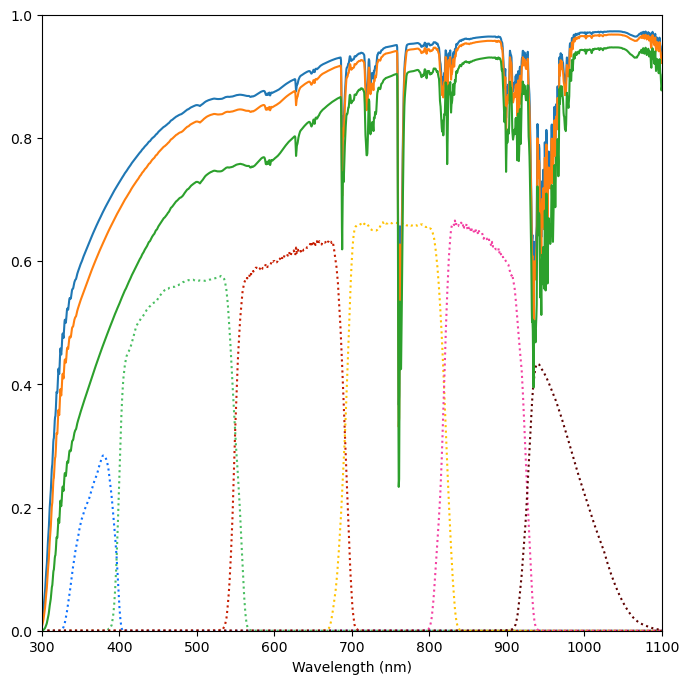

In [8]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

# Plot only if verbosity level is higher than 2...
if verbose > 2:
    
    colors = plot_filter_colors_white_background
    for f in flist:
        plt.plot(hardware[f].wavelen, hardware[f].sb, color=colors[f], linestyle=':')
    for x in [1.0, 1.2, 2.0]:
        #atmos files temporarily inaccessible from /sdf/data/rubin/shared/rubin_sim_data/throughputs/atmos;
        # using a temporary solution here:
        #atmosDir = '/home/d/dltucker/DATA/rubin_sim_data_throughputs/throughputs/atmos'
        #atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
        atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
        plt.plot(atmos.wavelen, atmos.sb, linestyle='-')
    plt.ylim(0, 1)
    plt.xlim(300, 1100)
    plt.xlabel("Wavelength (nm)")


### 2.3 Read in the CalSpec SED file and translate it into `rubin_sim` format 

In [9]:
# Read the sedfile

print(sed_key, sedfile_dict[sed_key])
    
# Read the SED file associated with this SED
sedfile = sedfile_dict[sed_key]
seddata = fits.getdata(sedfile)

# Transform the SED data into rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm     
sed = pt.Sed(wavelen=wavelen, flambda=flambda)

stiswfcnic_007 /home/d/dltucker/Downloads/c26202_stiswfcnic_007.fits


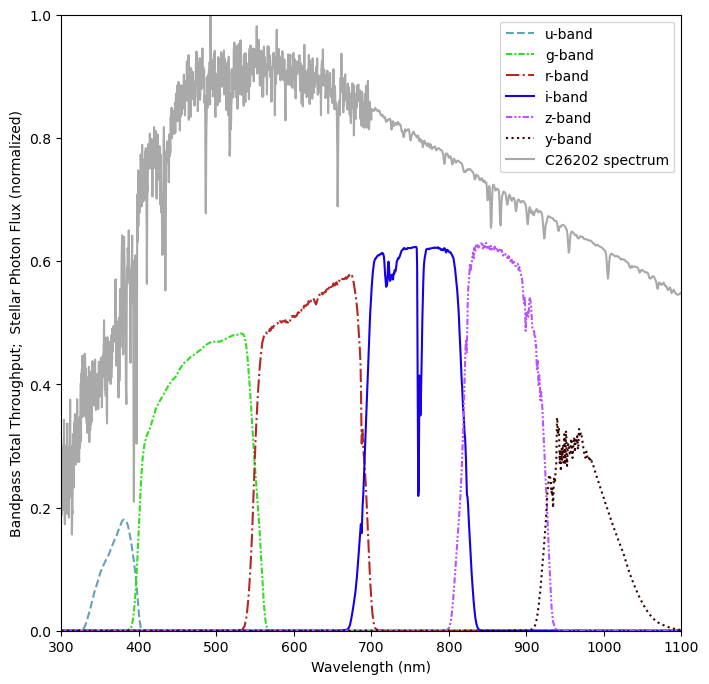

In [10]:
# Plot star spectrum (in normalized photon flux) with filter passbands

filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

x = 1.2
#atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')

# Create empty list to store legend handles
legend_handles = []

for f in flist:
    # Store the line handle when plotting
    line, = plt.plot(hardware[f].wavelen, hardware[f].sb*atmos.sb, 
                    color=filter_colors[f], 
                    linestyle=filter_linestyles[f],
                    label=f'{f}-band')  # Add label for each filter
    legend_handles.append(line)

# Constants
h = 6.626e-34  # Planck constant in J*s
c = 2.998e8    # Speed of light in m/s

# Calculate photon flux
wavelen_m = wavelen * 1e-9
flambda_joules = flambda * 1e-7
fphoton = flambda_joules * wavelen_m / (h * c)

# Store the stellar flux line handle
label = """%s spectrum""" % (Star_Name)
stellar_line, = plt.plot(wavelen, fphoton/max(fphoton), 
                        color='darkgrey', 
                        linestyle='-',
                        label=label)
legend_handles.append(stellar_line)

plt.xlim([300., 1100.])
plt.ylim([0.0, 1.0])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bandpass Total Throughput;  Stellar Photon Flux (normalized)")

# Add the legend
plt.legend(handles=legend_handles, loc='upper right')

### 2.4 Define the photometric parameters to use.

In [11]:
phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)


### 2.5 Calculate the expected counts for CalSpec star for the given photometric parameters over the airmass range of X=1.0-2.5

First, calculate the expected counts using the standard 30-second exposure time...

In [12]:
counts = {}
for f in flist:
    counts[f] = []
    for x in airmasses:
        counts[f].append(sed.calc_adu(system[x][f], phot_params))
    counts[f] = np.array(counts[f])


In [13]:
df_counts = pd.DataFrame(counts, index=airmasses)

if verbose > 0:
    display(df_counts)

,u,g,r,i,z,y
1.0,113903.105869,1.595908e+06,1.890467e+06,1.744171e+06,1.237520e+06,511370.756317
1.1,109275.963042,1.566471e+06,1.869171e+06,1.731662e+06,1.230557e+06,506026.651139
1.2,104807.807923,1.537421e+06,1.848023e+06,1.719303e+06,1.223682e+06,500876.179554
1.3,100591.008964,1.509309e+06,1.827389e+06,1.707290e+06,1.216981e+06,495993.849469
1.4,96523.963684,1.481599e+06,1.806919e+06,1.695410e+06,1.210361e+06,491263.396427
1.5,92605.673422,1.454303e+06,1.786604e+06,1.683664e+06,1.203814e+06,486671.720496
1.6,88903.509226,1.427871e+06,1.766785e+06,1.672193e+06,1.197413e+06,482291.964516
1.7,85272.693235,1.401409e+06,1.746835e+06,1.660711e+06,1.191004e+06,477955.867712
1.8,81823.590867,1.375675e+06,1.727279e+06,1.649434e+06,1.184714e+06,473778.556891
1.9,78675.598249,1.351499e+06,1.708712e+06,1.638668e+06,1.178680e+06,469887.749645


### 2.6 Output results to CSV file

In [14]:
if outputCSV:
    sedfile_base = os.path.splitext(os.path.basename(sedfile))[0]
    outputFile = f"{instrument}.{sedfile_base}.expected_counts.csv"
    print(f"Outputting expected counts to {outputFile}")
    df_counts.to_csv(outputFile, index=True)  #  Here, we want to keep the index for the DataFrame, which, in this case, is the airmass

Outputting expected counts to LSSTCam.c26202_stiswfcnic_007.expected_counts.csv


### 2.7 Create tophat passbands covering the same range of wavelengths of the original filter passbands

In [15]:
from copy import deepcopy
x=1.2
system_tophat = {}
for f in flist:
    system_tophat[f] = deepcopy(system[x][f])
    system_tophat[f].sb = np.where(system_tophat[f].sb >= 0.001, 1.0, 0.0)


Plot both the original (X=1.2) passbands and the tophat passbands together.

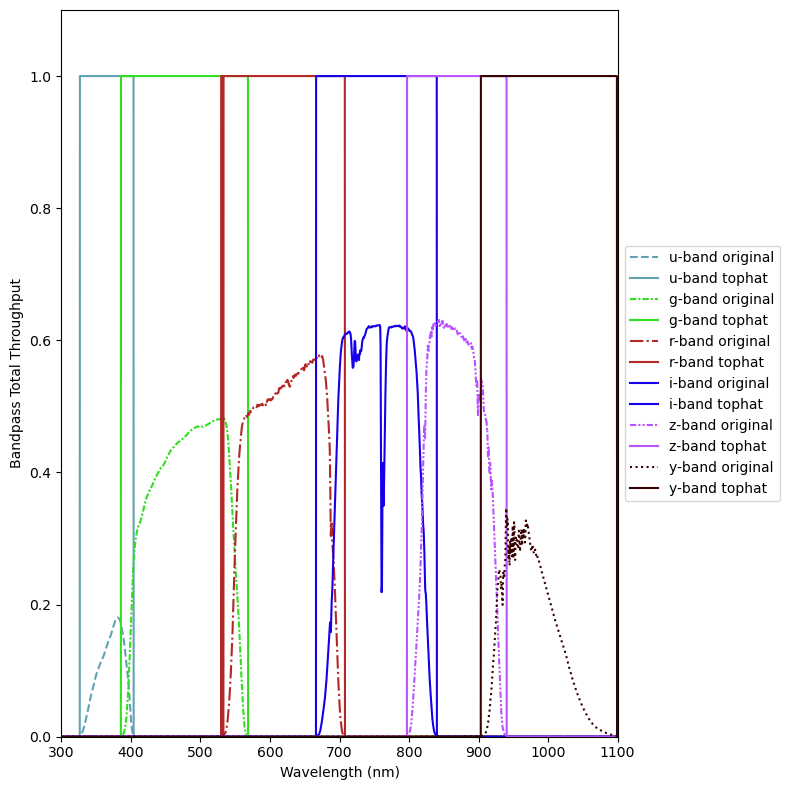

In [16]:
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

x = 1.2

# Create empty list to store legend handles
legend_handles = []

for f in flist:
    line, = plt.plot(system[x][f].wavelen, system[x][f].sb, 
                    color=filter_colors[f], 
                    linestyle=filter_linestyles[f],
                    label=f'{f}-band original')  # Add label for each filter
    legend_handles.append(line)

    line, = plt.plot(system_tophat[f].wavelen, system_tophat[f].sb, 
                    color=filter_colors[f], 
                    linestyle='-',
                    label=f'{f}-band tophat')  # Add label for each filter
    legend_handles.append(line)


plt.xlim([300., 1100.])
plt.ylim([0.0, 1.1])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bandpass Total Throughput")

# Add the legend
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # adjust layout so labels don’t get cut off

### 2.8 Calculate the expected counts for CalSpec star for the given photometric parameters for the tophat passbands

In [17]:
counts_tophat = {}
for f in flist:
    counts_tophat[f] = float(sed.calc_adu(system_tophat[f], phot_params))


In [18]:
counts_tophat

{'u': 1011878.1711799279,
 'g': 4185824.1978423614,
 'r': 4324881.931369704,
 'i': 3852309.9820743,
 'z': 2806449.0117231747,
 'y': 3323241.0773427063}

## 3. Query USDF Butler for exposures

### 3.1 Create query

In [19]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Build WHERE clause

where = f"instrument='{instrument}' AND day_obs>={day_obs_start} AND day_obs<={day_obs_end}"

# Query all exposure records in one go
results = list(registry.queryDimensionRecords("exposure", where=where))



### 3.2 Check that there are results; stop execution if there are none

In [20]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Stop executing if there are no results returned:

n_results = len(results)
if n_results == 0:
    raise StopExecution
else:
    print(f"There are {n_results} results returned from querying the butler for instrument {instrument} "
          f"between dates {day_obs_start} and {day_obs_end} (inclusive).")


There are 84666 results returned from querying the butler for instrument LSSTCam between dates 20250401 and 20251230 (inclusive).


### 3.3 Extract all rows into a list of tuples

In [21]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

rows = []
for info in results:
    try:
        rows.append((
            info.id,
            info.obs_id,
            info.day_obs,
            info.seq_num,
            info.timespan.begin,
            info.timespan.end,
            info.observation_type,
            info.observation_reason,
            info.target_name,
            info.physical_filter,
            info.zenith_angle,
            info.exposure_time,
            info.tracking_ra,
            info.tracking_dec,
            info.sky_angle,
            info.azimuth,
            info.zenith_angle,
            info.science_program
        ))
    except Exception as e:
        # Fallback values if timespan is missing or broken
        rows.append((
            info.id,
            info.obs_id,
            info.day_obs,
            info.seq_num,
            pd.to_datetime("2021-01-01 00:00:00.00"),
            pd.to_datetime("2051-01-01 00:00:00.00"),
            info.observation_type,
            info.observation_reason,
            info.target_name,
            info.physical_filter,
            info.zenith_angle,
            info.exposure_time,
            info.tracking_ra,
            info.tracking_dec,
            info.sky_angle,
            info.azimuth,
            info.zenith_angle,
            info.science_program
        ))


### 3.4 Build DataFrame in one shot

In [22]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

df_exp = pd.DataFrame(rows, columns=[
    'id', 'obs_id', 'day_obs', 'seq_num',
    'time_start', 'time_end', 'type', 'reason',
    'target', 'filter', 'zenith_angle',
    'expos', 'ra', 'dec', 'skyangle',
    'azimuth', 'zenith', 'science_program'
])

# Display current version of df_exp
#df_exp

### 3.5 Clean up DataFrame

In [23]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Compute JD and MJD vectorized
t_start = Time(df_exp['time_start'].tolist(), scale='tai')
df_exp['jd'] = t_start.jd
df_exp['mjd'] = t_start.mjd


In [24]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s:
df_exp = df_exp.astype({"id": int,'day_obs': int,'seq_num':int})

In [25]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Replace `NaN`'s in the `ra` and `dec` columns with zero.  
# (`NaN`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.) 
# ***(Maybe no longer necessary?)***

df_exp['ra'] = df_exp['ra'].fillna(0)
df_exp['dec'] = df_exp['dec'].fillna(0)

In [26]:
df_exp

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2025040400003,MC_C_20250404_000003,20250404,3,2460770.0975570185,2460770.097730822,dark,dark,UNKNOWN,unknown,NaN,15.0,0.0,0.0,NaN,NaN,NaN,unknown,2.460770e+06,60769.597557
1,2025040400006,MC_C_20250404_000006,20250404,6,2460770.0981735354,2460770.0983473263,dark,dark,UNKNOWN,unknown,NaN,15.0,0.0,0.0,NaN,NaN,NaN,unknown,2.460770e+06,60769.598174
2,2025040400001,MC_C_20250404_000001,20250404,1,2460770.097147471,2460770.0973212617,dark,dark,UNKNOWN,unknown,NaN,15.0,0.0,0.0,NaN,NaN,NaN,unknown,2.460770e+06,60769.597147
3,2025040400002,MC_C_20250404_000002,20250404,2,2460770.0973539185,2460770.0975277084,dark,dark,UNKNOWN,unknown,NaN,15.0,0.0,0.0,NaN,NaN,NaN,unknown,2.460770e+06,60769.597354
4,2025040400004,MC_C_20250404_000004,20250404,4,2460770.0977622764,2460770.097936065,dark,dark,UNKNOWN,unknown,NaN,15.0,0.0,0.0,NaN,NaN,NaN,unknown,2.460770e+06,60769.597762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84661,2025102200001,MC_O_20251022_000001,20251022,1,2460971.1838487,2460971.1840230785,dark,imagetesting,azel_target,none,89.987693,15.0,0.0,0.0,NaN,147.995264,89.987693,unknown,2.460971e+06,60970.683849
84662,2025102200002,MC_O_20251022_000002,20251022,2,2460971.184061163,2460971.184235914,dark,imagetesting,azel_target,none,89.987693,15.0,0.0,0.0,NaN,147.995264,89.987693,unknown,2.460971e+06,60970.684061
84663,2025102200003,MC_O_20251022_000003,20251022,3,2460971.1842728653,2460971.1844476387,dark,imagetesting,azel_target,none,89.987693,15.0,0.0,0.0,NaN,147.995264,89.987693,unknown,2.460971e+06,60970.684273
84664,2025102200004,MC_O_20251022_000004,20251022,4,2460971.184485837,2460971.184660486,dark,imagetesting,azel_target,none,89.987693,15.0,0.0,0.0,NaN,147.995264,89.987693,unknown,2.460971e+06,60970.684486


### 3.6 Add airmass to DataFrame

In [27]:
# Add an airmass to df_exp...

df_exp['airmass'] = np.round(1./np.cos(np.deg2rad(df_exp['zenith_angle'])), decimals=3)

In [28]:
# Printout zenith angle and airmass if verbosity level is greater than 1...
if verbose > 1:
    display(df_exp[['zenith_angle','airmass']])

,zenith_angle,airmass
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
84661,89.987693,4655.542
84662,89.987693,4655.542
84663,89.987693,4655.542
84664,89.987693,4655.542


### 3.7 Extract just "science" exposures

In [29]:
# Create a `DataFrame` containing just the science exposures:
df_sci = df_exp[df_exp.type == 'science']

In [30]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass, 
#  but only if verbosity level is greater than 1:
if verbose > 1:
    display(df_sci[['id', 'zenith_angle','airmass']])

,id,zenith_angle,airmass
2008,2025041201041,37.715703,1.264
2009,2025041201042,33.591132,1.200
2010,2025041201043,39.249548,1.291
2358,2025041300381,38.223392,1.273
2359,2025041300443,32.973360,1.192
...,...,...,...
84479,2025060900560,29.711753,1.151
84480,2025060900562,24.374480,1.098
84481,2025060900567,27.657473,1.129
84482,2025060900569,22.351916,1.081


### 3.8 Remove any exposures in the "bad visit" list

#### 3.8.1 Read in "bad visit" list

In [31]:
if instrument == "LSSTComCam":
    df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
    #df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)
else: 
    df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTCam/bad.ecsv").to_pandas()

# Look at bad visits table, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_bad_visits)

,exposure,comment
0,2025041700761,tracking stopped
1,2025041800615,trailed
2,2025042000501,trailed
3,2025042300237,trailed
4,2025042500457,messy PSF
...,...,...
369,2025082800177,donuts
370,2025082800178,donuts
371,2025090300314,lights on
372,2025092100042,trailed


#### 3.8.2 Remove from df_sci any exposures found in df_bad_visits

In [32]:
df_sci = df_sci[~df_sci['id'].isin(df_bad_visits['exposure'])]


In [33]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass, 
#  but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_sci[['id', 'zenith_angle','airmass']])

,id,zenith_angle,airmass
2008,2025041201041,37.715703,1.264
2009,2025041201042,33.591132,1.200
2010,2025041201043,39.249548,1.291
2358,2025041300381,38.223392,1.273
2359,2025041300443,32.973360,1.192
...,...,...,...
84479,2025060900560,29.711753,1.151
84480,2025060900562,24.374480,1.098
84481,2025060900567,27.657473,1.129
84482,2025060900569,22.351916,1.081


### 3.9 Save results as a CSV file

In [34]:
if outputCSV:
    outputFile = f"{instrument}.sci_exps.{day_obs_start}-{day_obs_end}.csv"
    print(f"Outputting exposures to {outputFile}")
    df_sci.to_csv(outputFile, index=False)

Outputting exposures to LSSTCam.sci_exps.20250401-20251230.csv


### 3.10 Create a Pandas DataFrame from df_sci that just contains the visit id, exposure time, zenith angle, and airmass

In [35]:
df_sci_airmass = df_sci[['id', 'expos', 'zenith_angle','airmass']].copy(deep=True)
df_sci_airmass.reset_index(drop=True, inplace=True)

# Look at pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_sci_airmass)

,id,expos,zenith_angle,airmass
0,2025041201041,30.0,37.715703,1.264
1,2025041201042,30.0,33.591132,1.200
2,2025041201043,30.0,39.249548,1.291
3,2025041300381,30.0,38.223392,1.273
4,2025041300443,30.0,32.973360,1.192
...,...,...,...,...
23398,2025060900560,30.0,29.711753,1.151
23399,2025060900562,30.0,24.374480,1.098
23400,2025060900567,30.0,27.657473,1.129
23401,2025060900569,30.0,22.351916,1.081


## 4. Query USDF Butler for measurements of CalSpec star

### 4.1 Find the `dataId`'s for all `visit_image`'s in this repo/collection that overlap the sky position of CalSpec star

In [36]:
datasetRefs = butler.query_datasets("visit_image", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

for i, ref in enumerate(datasetRefs):    
    print(i, ref.dataId)
    if ((verbose < 2) & (i >= 10)): 
        print("...")
        break


print(f"\nFound {len(datasetRefs)} visit_images")

0 {instrument: 'LSSTCam', detector: 44, visit: 2025090600260, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
1 {instrument: 'LSSTCam', detector: 49, visit: 2025090600252, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
2 {instrument: 'LSSTCam', detector: 51, visit: 2025090600256, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
3 {instrument: 'LSSTCam', detector: 51, visit: 2025090600266, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
4 {instrument: 'LSSTCam', detector: 51, visit: 2025090600280, band: 'r', day_obs: 20250906, physical_filter: 'r_57'}
5 {instrument: 'LSSTCam', detector: 52, visit: 2025082600442, band: 'i', day_obs: 20250826, physical_filter: 'i_39'}
6 {instrument: 'LSSTCam', detector: 52, visit: 2025082600445, band: 'i', day_obs: 20250826, physical_filter: 'i_39'}
7 {instrument: 'LSSTCam', detector: 52, visit: 2025090600254, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
8 {instrument: 'LSSTCam', detector: 52, visit: 2025090600259, ba

### 4.2 Create a pandas Dataframe containing the `source2` info for all these `visit_image`'s

#### 4.2.1 Loop over the `datasetRefs` again, grabbing the contents of the `source2` table for each `ref` and combining into all into one big pandas DataFrame.  

In [37]:
# Reference CALSPEC star coordinates
ref_coord = SkyCoord(ra=raDeg*u.degree, dec=decDeg*u.degree)

src_list = []

for i, ref in enumerate(datasetRefs):
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    src = butler.get('source2', dataId=dataId).to_pandas()
#    src = butler.get('recalibrated_star_detector', dataId=dataId).to_pandas()
# NOTE - source2 has more matches and gives a slightly different offset to recalibrated - which is going away soon (less than 2 mmag)

    # Apply "good measurement" mask immediately
    mask = (~src.pixelFlags_bad) & (~src.pixelFlags_saturated) & \
           (~src.extendedness_flag)
    src_cleaned = src[mask]

    # Compute separations to CALSPEC star
    df_coords = SkyCoord(ra=src_cleaned['ra'].values*u.degree,
                         dec=src_cleaned['dec'].values*u.degree)
    separations = ref_coord.separation(df_coords)

    # Keep only sources within 60 arcsec (for median aperture corrections later)
    mask_sep = separations < 60.0*u.arcsec
    nearby = src_cleaned[mask_sep].copy()
    nearby['separation_calspec'] = separations[mask_sep].arcsec
    
    if not nearby.empty:
        #best = nearby.sort_values('separation_calspec').iloc[[0]]
        #src_list.append(best)
        src_list.append(nearby)
        if ((verbose >= 2) | (i < 10)): 
            #print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}: "
            #      f"Found {len(best)} candidate matches.")
            print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}: "
                  f"Found {len(nearby)} candidate matches.")
        if ((verbose < 2) & (i == 10)): 
            print("...")
            
# Concatenate only the small filtered tables
if src_list:
    src_all = pd.concat(src_list, ignore_index=True)
    print(f"\nTotal combined catalog contains {len(src_all)} candidate sources.")
else:
    print("No matches found within 60 arcsec.")


0 Visit 2025090600260, Detector 44: Found 17 candidate matches.
1 Visit 2025090600252, Detector 49: Found 8 candidate matches.
2 Visit 2025090600256, Detector 51: Found 17 candidate matches.
3 Visit 2025090600266, Detector 51: Found 21 candidate matches.
4 Visit 2025090600280, Detector 51: Found 5 candidate matches.
5 Visit 2025082600442, Detector 52: Found 42 candidate matches.
6 Visit 2025082600445, Detector 52: Found 37 candidate matches.
7 Visit 2025090600254, Detector 52: Found 14 candidate matches.
8 Visit 2025090600259, Detector 52: Found 15 candidate matches.
9 Visit 2025090600253, Detector 53: Found 10 candidate matches.
10 Visit 2025090600270, Detector 53: Found 19 candidate matches.
11 Visit 2025090600285, Detector 53: Found 11 candidate matches.
12 Visit 2025090600277, Detector 60: Found 7 candidate matches.
13 Visit 2025090600274, Detector 61: Found 7 candidate matches.
14 Visit 2025090600278, Detector 61: Found 5 candidate matches.
15 Visit 2025090600262, Detector 86: Fou

In [38]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 1:
if verbose > 1:
    display(src_all)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,visit,detector,band,physical_filter,sourceId,separation_calspec
0,53.135752,-27.848272,0,2961.743035,675.446920,1.111372,0.990452,53.135752,-27.848272,5.308757e-05,...,False,False,False,False,2025090600260,44,z,z_20,25187647288770713,54.910738
1,53.136370,-27.850750,0,2993.324530,708.444860,0.799297,1.038077,53.136370,-27.850750,4.277689e-05,...,False,False,False,False,2025090600260,44,z,z_20,25187647288770723,45.906576
2,53.132638,-27.852950,0,2963.200236,773.111816,0.285195,0.220804,53.132638,-27.852950,1.323740e-05,...,False,False,False,False,2025090600260,44,z,z_20,25187647288770738,40.252561
3,53.152500,-27.864772,0,3343.751186,790.914926,1.170797,0.885172,53.152500,-27.864772,5.411164e-05,...,False,False,False,False,2025090600260,44,z,z_20,25187647288770746,50.033434
4,53.127867,-27.852600,0,2895.069302,807.144510,0.057855,0.052221,53.127867,-27.852600,2.771559e-06,...,False,False,False,False,2025090600260,44,z,z_20,25187647288770747,48.528528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,53.137016,-27.863438,25139291490353729,1727.637731,1498.537950,0.005785,0.006433,53.137016,-27.863438,3.112031e-07,...,False,False,False,False,2025082600429,102,g,g_6,25139291490354913,0.579846
2982,53.140379,-27.863508,25139291490353729,1748.148940,1547.934262,0.420236,0.589208,53.140379,-27.863508,2.776954e-05,...,False,False,False,False,2025082600429,102,g,g_6,25139291490354914,11.245524
2983,53.149846,-27.855172,25139291490353771,1946.229288,1624.831646,0.452740,0.440205,53.149846,-27.855172,2.174104e-05,...,False,False,False,False,2025082600429,102,g,g_6,25139291490354929,51.083863
2984,53.151533,-27.854976,25139291490353771,1960.328232,1647.940510,0.655166,0.672199,53.151533,-27.854976,3.290696e-05,...,False,False,False,False,2025082600429,102,g,g_6,25139291490354930,55.908676


#### 4.2.2 Add exposure time, zenith distance, and airmass to src_all

In [39]:
src_all_tmp = pd.merge(src_all, df_sci_airmass, left_on='visit', right_on='id')
src_all_tmp.drop('id', axis=1, inplace=True)
# Remove any rows for which airmass is a NaN
src_all_tmp.dropna(subset=['airmass'], inplace=True)
src_all = src_all_tmp

# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(src_all)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,sky_source,visit,detector,band,physical_filter,sourceId,separation_calspec,expos,zenith_angle,airmass
0,53.135752,-27.848272,0,2961.743035,675.446920,1.111372,0.990452,53.135752,-27.848272,5.308757e-05,...,False,2025090600260,44,z,z_20,25187647288770713,54.910738,30.0,59.582884,1.975
1,53.136370,-27.850750,0,2993.324530,708.444860,0.799297,1.038077,53.136370,-27.850750,4.277689e-05,...,False,2025090600260,44,z,z_20,25187647288770723,45.906576,30.0,59.582884,1.975
2,53.132638,-27.852950,0,2963.200236,773.111816,0.285195,0.220804,53.132638,-27.852950,1.323740e-05,...,False,2025090600260,44,z,z_20,25187647288770738,40.252561,30.0,59.582884,1.975
3,53.152500,-27.864772,0,3343.751186,790.914926,1.170797,0.885172,53.152500,-27.864772,5.411164e-05,...,False,2025090600260,44,z,z_20,25187647288770746,50.033434,30.0,59.582884,1.975
4,53.127867,-27.852600,0,2895.069302,807.144510,0.057855,0.052221,53.127867,-27.852600,2.771559e-06,...,False,2025090600260,44,z,z_20,25187647288770747,48.528528,30.0,59.582884,1.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,53.137016,-27.863438,25139291490353729,1727.637731,1498.537950,0.005785,0.006433,53.137016,-27.863438,3.112031e-07,...,False,2025082600429,102,g,g_6,25139291490354913,0.579846,30.0,41.995400,1.346
2982,53.140379,-27.863508,25139291490353729,1748.148940,1547.934262,0.420236,0.589208,53.140379,-27.863508,2.776954e-05,...,False,2025082600429,102,g,g_6,25139291490354914,11.245524,30.0,41.995400,1.346
2983,53.149846,-27.855172,25139291490353771,1946.229288,1624.831646,0.452740,0.440205,53.149846,-27.855172,2.174104e-05,...,False,2025082600429,102,g,g_6,25139291490354929,51.083863,30.0,41.995400,1.346
2984,53.151533,-27.854976,25139291490353771,1960.328232,1647.940510,0.655166,0.672199,53.151533,-27.854976,3.290696e-05,...,False,2025082600429,102,g,g_6,25139291490354930,55.908676,30.0,41.995400,1.346


#### 4.2.3 Add fractional flux error `apFlux_12_0_instFracFluxErr` to src_all

In [40]:
src_all['apFlux_12_0_instFracFluxErr'] = src_all['apFlux_12_0_instFluxErr']/src_all['apFlux_12_0_instFlux']


In [41]:
if verbose > 2:
    for c in src_all.columns:
        print(c)

coord_ra
coord_dec
parentSourceId
x
y
xErr
yErr
ra
dec
raErr
decErr
ra_dec_Cov
calibFlux
calibFluxErr
ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
sky
skyErr
psfFlux
psfFluxErr
ixx
iyy
ixy
ixxPSF
iyyPSF
ixyPSF
ixxDebiasedPSF
iyyDebiasedPSF
ixyDebiasedPSF
gaussianFlux
gaussianFluxErr
extendedness
sizeExtendedness
blendedness_abs
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux
apFlux_17_0_instFluxErr
apFlux_35_0_flag
apFlux_35_0_instFlux
apFlux_35_0_instFluxErr
apFlux_50_0_flag
apFlux_50_0_instFlux
apFlux_50_0_instFluxErr
normCompTo

In [42]:
if verbose > 2:
    for c in src_all.filter(regex='_inst').columns:
        print(c)


apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_instFlux
apFlux_17_0_instFluxErr
apFlux_35_0_instFlux
apFlux_35_0_instFluxErr
apFlux_50_0_instFlux
apFlux_50_0_instFluxErr
normCompTophatFlux_instFlux
normCompTophatFlux_instFluxErr
localBackground_instFlux
localBackground_instFluxErr
apFlux_12_0_instFracFluxErr


#### 4.2.3 Save `src_all` as a CSV file

In [43]:
if outputCSV:
    outputFile = f"{instrument}.{Star_Name}.source2.csv"
    print(f"Outputting observed source2 table results for {Star_Name} to {outputFile}")
    src_all.to_csv(outputFile, index=False)

Outputting observed source2 table results for C26202 to LSSTCam.C26202.source2.csv


## 5 Calculate psf to total flux aperture magnitudes on a per-visit basis

### 5.1 For historical reasons, define df_match to be src_all

In [44]:
# A TEMPORARY KLUDGE!
df_match = src_all.copy()

In [45]:
df_match

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,visit,detector,band,physical_filter,sourceId,separation_calspec,expos,zenith_angle,airmass,apFlux_12_0_instFracFluxErr
0,53.135752,-27.848272,0,2961.743035,675.446920,1.111372,0.990452,53.135752,-27.848272,5.308757e-05,...,2025090600260,44,z,z_20,25187647288770713,54.910738,30.0,59.582884,1.975,0.193934
1,53.136370,-27.850750,0,2993.324530,708.444860,0.799297,1.038077,53.136370,-27.850750,4.277689e-05,...,2025090600260,44,z,z_20,25187647288770723,45.906576,30.0,59.582884,1.975,0.093601
2,53.132638,-27.852950,0,2963.200236,773.111816,0.285195,0.220804,53.132638,-27.852950,1.323740e-05,...,2025090600260,44,z,z_20,25187647288770738,40.252561,30.0,59.582884,1.975,0.062619
3,53.152500,-27.864772,0,3343.751186,790.914926,1.170797,0.885172,53.152500,-27.864772,5.411164e-05,...,2025090600260,44,z,z_20,25187647288770746,50.033434,30.0,59.582884,1.975,0.141435
4,53.127867,-27.852600,0,2895.069302,807.144510,0.057855,0.052221,53.127867,-27.852600,2.771559e-06,...,2025090600260,44,z,z_20,25187647288770747,48.528528,30.0,59.582884,1.975,0.014357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,53.137016,-27.863438,25139291490353729,1727.637731,1498.537950,0.005785,0.006433,53.137016,-27.863438,3.112031e-07,...,2025082600429,102,g,g_6,25139291490354913,0.579846,30.0,41.995400,1.346,0.000856
2982,53.140379,-27.863508,25139291490353729,1748.148940,1547.934262,0.420236,0.589208,53.140379,-27.863508,2.776954e-05,...,2025082600429,102,g,g_6,25139291490354914,11.245524,30.0,41.995400,1.346,0.166505
2983,53.149846,-27.855172,25139291490353771,1946.229288,1624.831646,0.452740,0.440205,53.149846,-27.855172,2.174104e-05,...,2025082600429,102,g,g_6,25139291490354929,51.083863,30.0,41.995400,1.346,0.023597
2984,53.151533,-27.854976,25139291490353771,1960.328232,1647.940510,0.655166,0.672199,53.151533,-27.854976,3.290696e-05,...,2025082600429,102,g,g_6,25139291490354930,55.908676,30.0,41.995400,1.346,0.030666


### 5.2 Calculate values for per-visit `local_photoCalib` and use these values to back-calculate `psfFlux_inst` from `psfFlux`

***We do this since neither `psfFlux_inst` nor `local_photoCalib` seems to be in `source2`.***

#### 5.2.1 Calculate values for per-visit `local_photoCalib`

We use the 12-, 17-, 35-, and 50-pixel aperture fluxes. 

(Note that the values for `local_photoCalib` calculated from each of these aperture fluxes are (nearly) identical, with any differences typcially being at the 0.00001 level or smaller, most likely due to the clipping process in the calculation.  This is a good sign that `local_photoCalib` is well calculated.)

In [46]:
# Kudos to CoPilot+GPT5

# Define the apertures you want to process
apertures = {
    "12_0": ("ap12Flux", "apFlux_12_0_instFlux", "apFlux_12_0_flag"),
    "17_0": ("ap17Flux", "apFlux_17_0_instFlux", "apFlux_17_0_flag"),
    "35_0": ("ap35Flux", "apFlux_35_0_instFlux", "apFlux_35_0_flag"),
    "50_0": ("ap50Flux", "apFlux_50_0_instFlux", "apFlux_50_0_flag"),
}

# Dictionary to hold median calibration DataFrames
median_dfs = []

for ap_label, (flux_col, instflux_col, flag_col) in apertures.items():

    # Create the local calibration ratio column
    calib_col = f"local_photoCalib_{ap_label}"
    df_match[calib_col] = df_match[flux_col] / df_match[instflux_col]

    # Create mask
    #  Create a mask to cull sources with "bad" measurements.
    mask1 = (~df_match.pixelFlags_bad) & \
            (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & \
            (~df_match[flag_col])  
    #  Create an another mask to cull sources that are too faint or (possibly) too bright.
    flux_min = df_match[mask1][instflux_col].quantile(0.75)
    flux_max = df_match[mask1][instflux_col].quantile(0.95)
    # Combine masks
    mask = mask1 & \
        (df_match[instflux_col] >= flux_min) & \
        (df_match[instflux_col] < flux_max) & \
        (df_match.apFlux_12_0_instFracFluxErr >= 0.00) & \
        (df_match.apFlux_12_0_instFracFluxErr < 0.02)


    # Compute median per visit, ignoring NaNs
    median_series = (
        df_match[mask]
        .groupby("visit")[calib_col]
        .agg(lambda x: np.nanmedian(x))
    )

    # Convert to DataFrame and rename column
    median_df = median_series.reset_index().rename(
        columns={calib_col: calib_col}
    )
    median_dfs.append(median_df)

# Merge all median DataFrames on 'visit'
from functools import reduce
df_median_local_photoCalib = reduce(
    lambda left, right: pd.merge(left, right, on="visit", how="outer"),
    median_dfs
)

# Optional: inspect
if verbose > 1:
    display(df_median_local_photoCalib)


,visit,local_photoCalib_12_0,local_photoCalib_17_0,local_photoCalib_35_0,local_photoCalib_50_0
0,2025071100809,0.577459,0.577459,0.577459,0.577459
1,2025071100810,0.566166,0.566166,0.566166,0.566166
2,2025071100811,0.566388,0.566388,0.566388,0.566388
3,2025071100812,0.573676,0.573676,0.573676,0.573676
4,2025071100819,0.671226,0.671226,0.671226,0.671226
...,...,...,...,...,...
136,2025090600281,0.521323,0.521323,0.521323,0.521323
137,2025090600282,0.530767,0.530767,0.530767,0.530767
138,2025090600283,0.525160,0.525160,0.525160,0.525160
139,2025090600284,0.519817,0.519817,0.519817,0.519817


In [47]:
# Note:  the above procedure also appends these local_photoCalib_* columns to df_match:
if verbose > 2:
    display(df_match)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,sourceId,separation_calspec,expos,zenith_angle,airmass,apFlux_12_0_instFracFluxErr,local_photoCalib_12_0,local_photoCalib_17_0,local_photoCalib_35_0,local_photoCalib_50_0
0,53.135752,-27.848272,0,2961.743035,675.446920,1.111372,0.990452,53.135752,-27.848272,5.308757e-05,...,25187647288770713,54.910738,30.0,59.582884,1.975,0.193934,0.930480,0.930480,0.930480,0.930480
1,53.136370,-27.850750,0,2993.324530,708.444860,0.799297,1.038077,53.136370,-27.850750,4.277689e-05,...,25187647288770723,45.906576,30.0,59.582884,1.975,0.093601,0.930518,0.930518,0.930518,0.930518
2,53.132638,-27.852950,0,2963.200236,773.111816,0.285195,0.220804,53.132638,-27.852950,1.323740e-05,...,25187647288770738,40.252561,30.0,59.582884,1.975,0.062619,0.930553,0.930553,0.930553,0.930553
3,53.152500,-27.864772,0,3343.751186,790.914926,1.170797,0.885172,53.152500,-27.864772,5.411164e-05,...,25187647288770746,50.033434,30.0,59.582884,1.975,0.141435,0.930737,0.930737,0.930737,0.930737
4,53.127867,-27.852600,0,2895.069302,807.144510,0.057855,0.052221,53.127867,-27.852600,2.771559e-06,...,25187647288770747,48.528528,30.0,59.582884,1.975,0.014357,0.930548,0.930548,0.930548,0.930548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,53.137016,-27.863438,25139291490353729,1727.637731,1498.537950,0.005785,0.006433,53.137016,-27.863438,3.112031e-07,...,25139291490354913,0.579846,30.0,41.995400,1.346,0.000856,0.497150,0.497150,0.497150,0.497150
2982,53.140379,-27.863508,25139291490353729,1748.148940,1547.934262,0.420236,0.589208,53.140379,-27.863508,2.776954e-05,...,25139291490354914,11.245524,30.0,41.995400,1.346,0.166505,0.497173,0.497173,0.497173,0.497173
2983,53.149846,-27.855172,25139291490353771,1946.229288,1624.831646,0.452740,0.440205,53.149846,-27.855172,2.174104e-05,...,25139291490354929,51.083863,30.0,41.995400,1.346,0.023597,0.497350,0.497350,0.497350,0.497350
2984,53.151533,-27.854976,25139291490353771,1960.328232,1647.940510,0.655166,0.672199,53.151533,-27.854976,3.290696e-05,...,25139291490354930,55.908676,30.0,41.995400,1.346,0.030666,0.497364,0.497364,0.497364,0.497364


#### 5.2.2 Back-calculate psfFlux_inst from psfFlux

In [48]:
# Use local_photoCalib_12_0 for the conversion
df_match['psfFlux_instFlux'] = df_match['psfFlux']/df_match['local_photoCalib_12_0']

# Optional: inspect
if verbose > 2:
    display(df_match)


,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,separation_calspec,expos,zenith_angle,airmass,apFlux_12_0_instFracFluxErr,local_photoCalib_12_0,local_photoCalib_17_0,local_photoCalib_35_0,local_photoCalib_50_0,psfFlux_instFlux
0,53.135752,-27.848272,0,2961.743035,675.446920,1.111372,0.990452,53.135752,-27.848272,5.308757e-05,...,54.910738,30.0,59.582884,1.975,0.193934,0.930480,0.930480,0.930480,0.930480,7.853871e+03
1,53.136370,-27.850750,0,2993.324530,708.444860,0.799297,1.038077,53.136370,-27.850750,4.277689e-05,...,45.906576,30.0,59.582884,1.975,0.093601,0.930518,0.930518,0.930518,0.930518,1.468446e+04
2,53.132638,-27.852950,0,2963.200236,773.111816,0.285195,0.220804,53.132638,-27.852950,1.323740e-05,...,40.252561,30.0,59.582884,1.975,0.062619,0.930553,0.930553,0.930553,0.930553,2.854446e+04
3,53.152500,-27.864772,0,3343.751186,790.914926,1.170797,0.885172,53.152500,-27.864772,5.411164e-05,...,50.033434,30.0,59.582884,1.975,0.141435,0.930737,0.930737,0.930737,0.930737,1.043704e+04
4,53.127867,-27.852600,0,2895.069302,807.144510,0.057855,0.052221,53.127867,-27.852600,2.771559e-06,...,48.528528,30.0,59.582884,1.975,0.014357,0.930548,0.930548,0.930548,0.930548,1.272606e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981,53.137016,-27.863438,25139291490353729,1727.637731,1498.537950,0.005785,0.006433,53.137016,-27.863438,3.112031e-07,...,0.579846,30.0,41.995400,1.346,0.000856,0.497150,0.497150,0.497150,0.497150,1.506889e+06
2982,53.140379,-27.863508,25139291490353729,1748.148940,1547.934262,0.420236,0.589208,53.140379,-27.863508,2.776954e-05,...,11.245524,30.0,41.995400,1.346,0.166505,0.497173,0.497173,0.497173,0.497173,2.165380e+03
2983,53.149846,-27.855172,25139291490353771,1946.229288,1624.831646,0.452740,0.440205,53.149846,-27.855172,2.174104e-05,...,51.083863,30.0,41.995400,1.346,0.023597,0.497350,0.497350,0.497350,0.497350,1.432364e+04
2984,53.151533,-27.854976,25139291490353771,1960.328232,1647.940510,0.655166,0.672199,53.151533,-27.854976,3.290696e-05,...,55.908676,30.0,41.995400,1.346,0.030666,0.497364,0.497364,0.497364,0.497364,1.053620e+04


### 5.3 Create dataframe containing the visit-by-visit median psf-to-total flux aperture corrections.

In [49]:
# Create a column containing the aperture-to-total flux aperture correction for each individual source.

#  We will use 'psfFlux_instFlux' as our primary instrumental flux measurement.
#  We will take 'apFlux_50_0_instFlux' as the total flux.
df_match['apCorrTot'] = df_match['apFlux_50_0_instFlux'] / df_match['psfFlux_instFlux']

# Create a mask to cull sources with "bad" measurements.
mask1 = (~df_match.pixelFlags_bad) & \
        (~df_match.pixelFlags_saturated) & \
        (~df_match.extendedness_flag) & \
        (~df_match.apFlux_12_0_flag) & \
        (~df_match.apFlux_50_0_flag)  

# Create an another mask to cull sources that are too faint or (possibly) too bright.
flux_min = df_match[mask1]['psfFlux_instFlux'].quantile(0.75)
flux_max = df_match[mask1]['psfFlux_instFlux'].quantile(0.95)
mask = mask1 & \
        (df_match.psfFlux_instFlux >= flux_min) & \
        (df_match.psfFlux_instFlux < flux_max)  & \
        (df_match.apFlux_12_0_instFracFluxErr >= 0.00) & \
        (df_match.apFlux_12_0_instFracFluxErr < 0.01)

# Calculate median ratio per visit, ignoring NaNs
median_apCorrTots = df_match[mask].groupby('visit')['apCorrTot'].agg(lambda x: np.nanmedian(x))

# Create a pandas DataFrame out of this pandas Series
df_median_apCorrTots = median_apCorrTots.reset_index()

# Rename `apCorrTot` to `apCorrTot_median` in df_median_apCorrTots
df_median_apCorrTots.rename(columns={'apCorrTot': 'apCorrTot_median'}, inplace=True)

## Remove the original apCorrTot column from df_match
#df_match.drop('apCorrTot', axis=1, inplace=True)

# Show the dataframe of median apCorrTots by visit id, 
#  but only if verbosity level is greater than 1:
if verbose > 1:
    display(df_median_apCorrTots)

,visit,apCorrTot_median
0,2025071100819,1.042972
1,2025071100820,1.051144
2,2025071200713,1.071157
3,2025071200714,1.059904
4,2025071200735,1.079678
...,...,...
126,2025090600281,1.077163
127,2025090600282,1.082965
128,2025090600283,1.019797
129,2025090600284,1.006027


### 5.4 Add the visit-by-visit median aperture corrections to the `df_match`pandas DataFrame

In [50]:
df_match = df_match.merge(df_median_apCorrTots, on='visit')

In [51]:
# Display result sorted in ascending order of visit (primarily) and RA (secondarily), 
#  but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_match.sort_values(by=['visit', 'ra']))

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,zenith_angle,airmass,apFlux_12_0_instFracFluxErr,local_photoCalib_12_0,local_photoCalib_17_0,local_photoCalib_35_0,local_photoCalib_50_0,psfFlux_instFlux,apCorrTot,apCorrTot_median
629,53.122057,-27.865421,0,3946.920362,3338.840171,0.682266,1.157159,53.122057,-27.865421,3.663543e-05,...,62.331036,2.153,0.289086,0.671247,0.671247,0.671247,0.671247,8.500307e+03,1.786012,1.042972
2705,53.122057,-27.865421,0,3946.920362,3338.840171,0.682266,1.157159,53.122057,-27.865421,3.663543e-05,...,62.331036,2.153,0.289086,0.671247,0.671247,0.671247,0.671247,8.500307e+03,1.786012,1.042972
630,53.124954,-27.875108,0,3934.401444,3518.824973,0.019828,0.020701,53.124954,-27.875108,9.786555e-07,...,62.331036,2.153,0.005701,0.671226,0.671226,0.671226,0.671226,3.942084e+05,1.042972,1.042972
2706,53.124954,-27.875108,0,3934.401444,3518.824973,0.019828,0.020701,53.124954,-27.875108,9.786555e-07,...,62.331036,2.153,0.005701,0.671226,0.671226,0.671226,0.671226,3.942084e+05,1.042972,1.042972
632,53.149938,-27.855156,24937033694184104,177.959948,3305.999051,0.503772,0.302122,53.149938,-27.855156,2.392533e-05,...,62.331036,2.153,0.059156,0.670862,0.670862,0.670862,0.670862,2.538120e+04,2.377304,1.042972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,53.137025,-27.863437,0,1037.285725,2937.621034,0.005362,0.005029,53.137025,-27.863437,2.580141e-07,...,55.822736,1.780,0.001456,0.518374,0.518374,0.518374,0.518374,1.989738e+06,1.061868,1.044248
199,53.137993,-27.874013,0,937.835727,3100.634046,0.646979,0.587351,53.137993,-27.874013,3.081603e-05,...,55.822736,1.780,0.352003,0.518279,0.518279,0.518279,0.518279,7.720150e+03,-2.082477,1.044248
200,53.139950,-27.878521,0,915.312781,3184.544779,1.988822,1.835042,53.139950,-27.878521,9.519735e-05,...,55.822736,1.780,0.115226,0.518240,0.518240,0.518240,0.518240,1.360652e+04,2.662799,1.044248
201,53.149859,-27.855171,25187650648932847,1289.795270,2937.331787,0.888643,0.616064,53.149859,-27.855171,3.956585e-05,...,55.822736,1.780,0.056804,0.518466,0.518466,0.518466,0.518466,2.383794e+04,1.361012,1.044248


## 6. Extract the rows containing CalSpec star from the df_match catalog

In [52]:
# Based on code retrieved from Claude-3.5-Sonnet

# Create a mask to cull sources with "bad" measurements.
mask1 = (~df_match.pixelFlags_bad) & \
        (~df_match.pixelFlags_saturated) & \
        (~df_match.extendedness_flag) & \
        (~df_match.apFlux_12_0_flag) & \
        (~df_match.psfFlux_flag)  

mask = mask1 & \
        (df_match.apFlux_12_0_instFracFluxErr >= 0.00) & \
        (df_match.apFlux_12_0_instFracFluxErr < 0.01)


# Apply mask, keeping only the "good" measurements of `df_match`
df_match_cleaned = df_match[mask]

# Create SkyCoord object for the coordinates of CalSpec star
ref_coord = SkyCoord(ra=raDeg*u.degree, dec=decDeg*u.degree)

# Create SkyCoord object for all points in the dataframe
df_coords = SkyCoord(ra=df_match_cleaned['ra'].values*u.degree, 
                     dec=df_match_cleaned['dec'].values*u.degree)

# Calculate separations
separations = ref_coord.separation(df_coords)

# Create mask for points within 3.0 arcseconds
mask_sep = separations < 3.0*u.arcsec

# Get filtered dataframe
nearby_good_df = df_match_cleaned[mask_sep]

# If you want to include the separations in the result
orig_columns = nearby_good_df.columns
nearby_good_df = df_match_cleaned[mask_sep].copy()
nearby_good_df['separation_calspec'] = separations[mask_sep].arcsec

# Find (and keep) the closet match within the match radius
best_df = nearby_good_df.sort_values('separation_calspec').drop_duplicates(subset=orig_columns, keep='first')


In [53]:
# Display the resulting table, but only if verbosity level is greater than 1:
if verbose > 1:
    display(best_df)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,zenith_angle,airmass,apFlux_12_0_instFracFluxErr,local_photoCalib_12_0,local_photoCalib_17_0,local_photoCalib_35_0,local_photoCalib_50_0,psfFlux_instFlux,apCorrTot,apCorrTot_median
1640,53.136985,-27.863430,0,522.063458,3792.717924,0.005619,0.005013,53.136985,-27.863430,2.560901e-07,...,63.627418,2.251,0.000927,0.530748,0.530748,0.530748,0.530748,1.415801e+06,1.059905,1.022133
1627,53.137003,-27.863465,0,529.107695,3793.457698,0.005786,0.004906,53.137003,-27.863465,2.553826e-07,...,63.756196,2.261,0.000925,0.528903,0.528903,0.528903,0.528903,1.428837e+06,1.049881,0.996450
1580,53.136997,-27.863445,0,546.797550,3795.530116,0.006990,0.005904,53.136997,-27.863445,3.078240e-07,...,64.143111,2.293,0.000943,0.547633,0.547633,0.547633,0.547633,1.371855e+06,1.070208,1.077441
1330,53.136995,-27.863440,0,1355.931412,2673.496934,0.005517,0.006224,53.136995,-27.863440,3.053195e-07,...,61.746488,2.112,0.000921,0.529843,0.529843,0.529843,0.529843,1.415920e+06,1.079523,1.033206
1565,53.137001,-27.863452,0,547.679582,3796.243439,0.006850,0.004906,53.137001,-27.863452,2.743066e-07,...,64.272051,2.304,0.000935,0.540161,0.540161,0.540161,0.540161,1.397732e+06,1.063690,1.049941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,53.137036,-27.863431,0,1362.317315,2613.913458,0.004076,0.003938,53.137036,-27.863431,1.938817e-07,...,58.851620,1.933,0.000968,0.618460,0.618460,0.618460,0.618460,1.876343e+06,1.044924,1.067010
217,53.137040,-27.863434,0,3574.700647,592.030804,0.009348,0.008225,53.137040,-27.863434,4.483533e-07,...,59.677384,1.981,0.001688,0.916565,0.916565,0.916565,0.916565,1.270626e+06,1.112678,1.093193
2207,53.137041,-27.863433,0,1882.840878,3416.943736,0.006495,0.006093,53.137041,-27.863433,3.091225e-07,...,57.517653,1.862,0.001265,0.883177,0.883177,0.883177,0.883177,1.315716e+06,1.057346,1.078967
42,53.137038,-27.863425,0,1189.991493,2534.287422,0.007879,0.006267,53.137038,-27.863425,3.794090e-07,...,58.860197,1.934,0.001626,0.880715,0.880715,0.880715,0.880715,1.320116e+06,1.063530,1.061044


In [54]:
# Display only the most relevant columns of the resulting table, 
# but only if verbosity level is greater than 0:
if verbose > 0:
    #display(best_df[['visit', 'band', 'expos', 'airmass', 'apFlux_12_0_instFlux', 'apCorrTot_median']])
    display(best_df[['visit', 'band', 'expos', 'airmass', 'psfFlux_instFlux', 'apCorrTot_median']])

,visit,band,expos,airmass,psfFlux_instFlux,apCorrTot_median
1640,2025072100529,g,30.0,2.251,1.415801e+06,1.022133
1627,2025072100528,g,30.0,2.261,1.428837e+06,0.996450
1580,2025072100525,g,30.0,2.293,1.371855e+06,1.077441
1330,2025071900577,g,30.0,2.112,1.415920e+06,1.033206
1565,2025072100524,g,30.0,2.304,1.397732e+06,1.049941
...,...,...,...,...,...,...
1543,2025071900590,i,30.0,1.933,1.876343e+06,1.067010
217,2025090600262,z,30.0,1.981,1.270626e+06,1.093193
2207,2025072800370,z,30.0,1.862,1.315716e+06,1.078967
42,2025090600266,z,30.0,1.934,1.320116e+06,1.061044


In [55]:
#for colname in best_df.columns:
#    print(colname)

## 7. Calculate the ratio of observed to expected throughputs for instrument based on CalSpec star


### 7.1 Add a column to `best_df` containing the expected counts for CalSpec star based on the contents of `df_counts` created earlier

We will use the `interp1d` interpolation function from the `scipy.interpolate` package to perform linear interpolations between the airmasses listed in `df_counts`.

In [56]:
# Based on code retrieved from Claude-3.5-Sonnet

from scipy.interpolate import interp1d

# Create a dictionary to store interpolation functions for each band
interpolators = {}
for band in flist:
    interpolators[band] = interp1d(df_counts.index, 
                                 df_counts[band], 
                                 kind='linear',
                                 bounds_error=False,    # Return nan for out of bounds
                                 fill_value=np.nan)

# Create new column with interpolated values
best_df['total_counts_expected'] = best_df.apply(
    lambda row: interpolators[row['band']](row['airmass']), 
    axis=1
)

# You can check the results if verbosity level is greater than 0):
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'total_counts_expected']])

# Optional: Check for any NaN values (would indicate airmass outside interpolation range)
nan_matches = best_df[best_df['total_counts_expected'].isna()]
if len(nan_matches) > 0:
    print("\nRows with no matches (airmass out of range):")
    print(nan_matches[['visit', 'band', 'airmass']])

,visit,band,airmass,total_counts_expected
1640,2025072100529,g,2.251,1267806.5312126346
1627,2025072100528,g,2.261,1265455.4845629362
1580,2025072100525,g,2.293,1257932.1352839016
1330,2025071900577,g,2.112,1299384.3986033595
1565,2025072100524,g,2.304,1255351.0958525224
...,...,...,...,...
1543,2025071900590,i,1.933,1635014.7211079684
217,2025090600262,z,1.981,1173675.6637797863
2207,2025072800370,z,1.862,1180973.2271098674
42,2025090600266,z,1.934,1176579.5395011867


### 7.2 Add columns to `best_df` containing the total counts observed and the ratio of total counts observed to total counts expected


In [57]:
best_df['total_counts_observed'] = best_df['apCorrTot_median'] * best_df['psfFlux_instFlux']
# We will rescale total_counts_observed to a 30-second exposure for those 
#  (u-band) visits that have a 38-second exposure time:
best_df['total_counts_observed'] = (30./best_df['expos'])*best_df['total_counts_observed']
best_df['ratio_obs_exp'] = best_df['total_counts_observed'] / best_df['total_counts_expected']

Let's look at them...

In [58]:
# Set pandas to show all rows (but only if verbosity level is greater than 1)...
if verbose > 1:
    pd.set_option("display.max_rows", None)

In [59]:
# Output to screen the most relevant columns for all rows, 
#  but only if verbosity level is greater than 0...
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'expos', 'psfFlux_instFlux', 'apCorrTot_median', 'total_counts_observed', 'total_counts_expected', 'ratio_obs_exp']])

,visit,band,airmass,expos,psfFlux_instFlux,apCorrTot_median,total_counts_observed,total_counts_expected,ratio_obs_exp
1640,2025072100529,g,2.251,30.0,1.415801e+06,1.022133,1.447137e+06,1267806.5312126346,1.141449
1627,2025072100528,g,2.261,30.0,1.428837e+06,0.996450,1.423764e+06,1265455.4845629362,1.1251
1580,2025072100525,g,2.293,30.0,1.371855e+06,1.077441,1.478093e+06,1257932.1352839016,1.175018
1330,2025071900577,g,2.112,30.0,1.415920e+06,1.033206,1.462937e+06,1299384.3986033595,1.125869
1565,2025072100524,g,2.304,30.0,1.397732e+06,1.049941,1.467535e+06,1255351.0958525224,1.169024
1592,2025072100526,g,2.282,30.0,1.386702e+06,1.073217,1.488233e+06,1260518.2865985697,1.180651
1609,2025072100527,g,2.272,30.0,1.414021e+06,1.050052,1.484795e+06,1262869.333248268,1.175732
1367,2025071900579,g,2.095,30.0,1.421506e+06,1.042592,1.482051e+06,1303279.4462204094,1.13717
1299,2025071900575,g,2.130,30.0,1.419598e+06,1.049552,1.489941e+06,1295377.8584830102,1.150198
2636,2025082600425,g,1.359,30.0,1.598166e+06,1.053595,1.683819e+06,1492959.83719893,1.12784


In [60]:
# Reset pandas to its default maximum rows to print to screen
# (if it had been reset earlier due to verbosity level greater than 1)...
if verbose > 1:
    pd.reset_option("display.max_rows")

### 7.3 Plot a histogram of the ratio of total counts observed to total counts for each passband

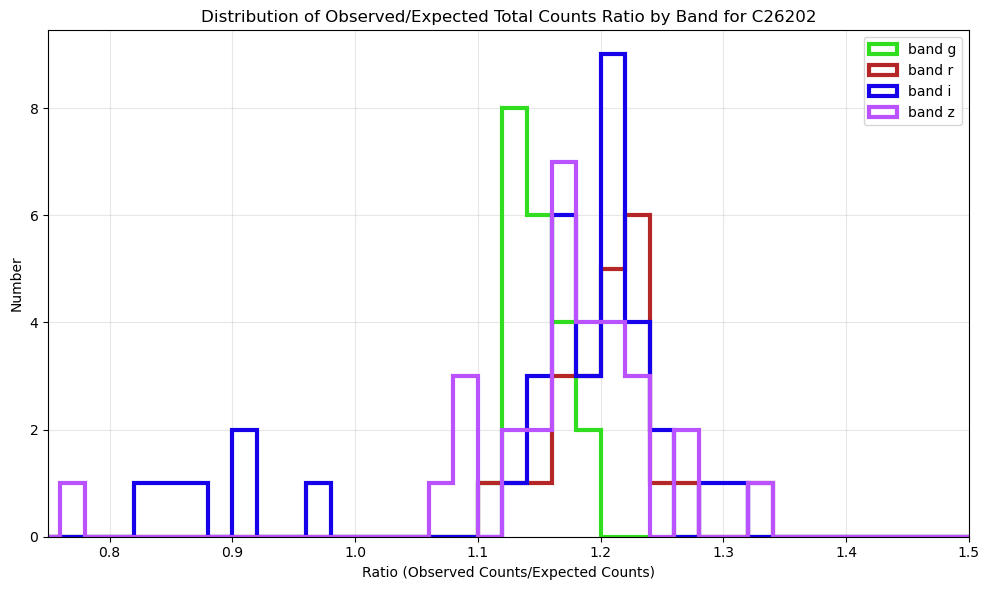

In [61]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level
linewidth = 3 # linewidth for the step histogram lines 

# Define bins.  Here, we want to look around ratio=1.00+/-0.20 in steps of 0.01
#bins = np.arange(0.80, 1.20, 0.01)
#bins = np.arange(0.00, 2.00, 0.01)
bins = np.arange(0.00, 2.00, 0.02)

# Plot histogram for each band
for band in flist:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:  # only plot if we have data for this band
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=colors[band],
        #        density=False)  # density=True normalizes the area
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=filter_colors[band],
        #        linestyle=filter_linestyles[band], 
        #        density=False)  # density=True normalizes the area
        plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
                label=f'band {band}', color=filter_colors[band],
                density=False)  # density=True normalizes the area


plt.xlabel('Ratio (Observed Counts/Expected Counts)')
plt.ylabel('Number')
#plt.xlim([0.75, 1.15])
plt.xlim([0.75, 1.50])
#plt.xlim([0.00, 2.00])

plot_title = """Distribution of Observed/Expected Total Counts Ratio by Band for %s""" % (Star_Name)
plt.title(plot_title)
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



### 7.3 Print summary statistics for each band

Let's output a nice table...

In [62]:
# Based on code retrieved from Claude-3.5-Sonnet and from CoPilot+GPT5

stats_data = []

for band in flist:
    # Extract and clean the data
    band_data = best_df.loc[best_df['band'] == band, 'ratio_obs_exp']
    band_data = pd.to_numeric(band_data, errors='coerce')  # force numeric
    band_data = band_data.replace([np.inf, -np.inf], np.nan).dropna().values.astype(float)

    if len(band_data) > 0:
        # --- Option A: sigma-clipped stats ---
        mean_clip, median_clip, std_clip = sigma_clipped_stats(band_data, sigma=3.0, maxiters=5)
        stderr_clip = std_clip / np.sqrt(len(band_data))

        # --- Option B: robust median/MAD ---
        median_robust = np.median(band_data)
        std_robust = mad_std(band_data)
        stderr_robust = std_robust / np.sqrt(len(band_data))

        stats_data.append({
            'band': band,
            'n_band': len(band_data),
            'Mean (clip)': f"{mean_clip:.3f}",
            'Median (clip)': f"{median_clip:.3f}",
            'Std (clip)': f"{std_clip:.3f}",
            'StdErr (clip)': f"{stderr_clip:.3f}",
            'Median (robust)': f"{median_robust:.3f}",
            'Std (robust)': f"{std_robust:.3f}",
            'StdErr (robust)': f"{stderr_robust:.3f}"
        })
    else:
        stats_data.append({
            'band': band,
            'n_band': 0,
            'Mean (clip)': 'N/A',
            'Median (clip)': 'N/A',
            'Std (clip)': 'N/A',
            'StdErr (clip)': 'N/A',
            'Median (robust)': 'N/A',
            'Std (robust)': 'N/A',
            'StdErr (robust)': 'N/A'
        })

# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Display the full table
display(stats_df)
#print(stats_df.to_string(index=False))

# Display a truncated table
display(stats_df[['band', 'n_band', 'Mean (clip)', 'Median (clip)', 'StdErr (clip)']])


,band,n_band,Mean (clip),Median (clip),Std (clip),StdErr (clip),Median (robust),Std (robust),StdErr (robust)
0,u,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,g,23,1.148,1.146,0.021,0.004,1.141,0.024,0.005
2,r,29,1.042,1.198,0.322,0.060,1.198,0.052,0.010
3,i,36,1.150,1.193,0.124,0.021,1.193,0.046,0.008
4,z,35,1.092,1.177,0.207,0.035,1.177,0.063,0.011
5,y,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,band,n_band,Mean (clip),Median (clip),StdErr (clip)
0,u,0,N/A,N/A,N/A
1,g,23,1.148,1.146,0.004
2,r,29,1.042,1.198,0.060
3,i,36,1.150,1.193,0.021
4,z,35,1.092,1.177,0.035
5,y,0,N/A,N/A,N/A


## 8. Calculate the absolute throughputs for instrument based on CalSpec star


We do this by comparing the observed throughputs from the real filters to the expected throughputs from the tophat filters.

### 8.1 Add columns to `best_df` containing the total expected counts from the tophat filters and the ratio of total counts observed from the real filters to total counts expected from the tophat filters


In [63]:
df_counts_tophat = pd.Series(counts_tophat, name="total_counts_expected_tophat")
best_df = best_df.join(df_counts_tophat, on="band")
best_df['abs_throughput'] = best_df['total_counts_observed'] / best_df['total_counts_expected_tophat']


In [64]:
# Set pandas to show all rows (but only if verbosity level is greater than 1)...
if verbose > 1:
    pd.set_option("display.max_rows", None)

In [65]:
# Output to screen the most relevant columns for all rows, 
#  but only if verbosity level is greater than 0...
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'expos', 'total_counts_observed', 'total_counts_expected_tophat', 'abs_throughput']])

,visit,band,airmass,expos,total_counts_observed,total_counts_expected_tophat,abs_throughput
1640,2025072100529,g,2.251,30.0,1.447137e+06,4.185824e+06,0.345723
1627,2025072100528,g,2.261,30.0,1.423764e+06,4.185824e+06,0.340139
1580,2025072100525,g,2.293,30.0,1.478093e+06,4.185824e+06,0.353119
1330,2025071900577,g,2.112,30.0,1.462937e+06,4.185824e+06,0.349498
1565,2025072100524,g,2.304,30.0,1.467535e+06,4.185824e+06,0.350596
1592,2025072100526,g,2.282,30.0,1.488233e+06,4.185824e+06,0.355541
1609,2025072100527,g,2.272,30.0,1.484795e+06,4.185824e+06,0.354720
1367,2025071900579,g,2.095,30.0,1.482051e+06,4.185824e+06,0.354064
1299,2025071900575,g,2.130,30.0,1.489941e+06,4.185824e+06,0.355949
2636,2025082600425,g,1.359,30.0,1.683819e+06,4.185824e+06,0.402267


In [66]:
# Reset pandas to its default maximum rows to print to screen
# (if it had been reset earlier due to verbosity level greater than 1)...
if verbose > 1:
    pd.reset_option("display.max_rows")

### 8.2 Plot a histogram and a scatter plot of the absolute throughputs for each passband

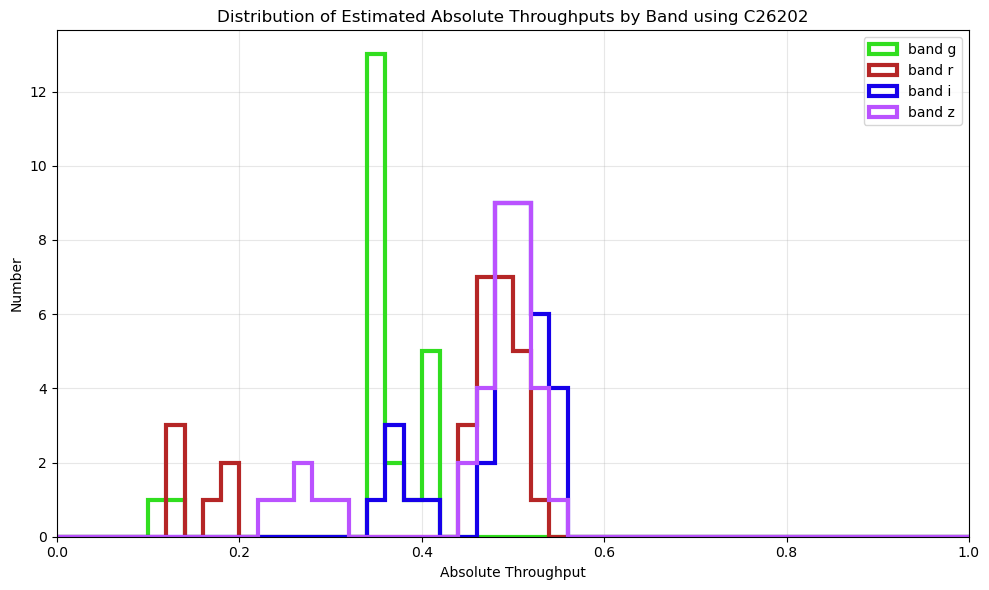

In [67]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level
linewidth = 3 # linewidth for the step histogram lines 

# Define bins.  Here, we want to look around ratio=1.00+/-0.20 in steps of 0.01
#bins = np.arange(0.80, 1.20, 0.01)
#bins = np.arange(0.00, 2.00, 0.01)
bins = np.arange(0.00, 2.00, 0.02)

# Plot histogram for each band
for band in flist:
    band_data = best_df[best_df['band'] == band]['abs_throughput']
    if len(band_data) > 0:  # only plot if we have data for this band
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=colors[band],
        #        density=False)  # density=True normalizes the area
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=filter_colors[band],
        #        linestyle=filter_linestyles[band], 
        #        density=False)  # density=True normalizes the area
        plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
                label=f'band {band}', color=filter_colors[band],
                density=False)  # density=True normalizes the area


plt.xlabel('Absolute Throughput')
plt.ylabel('Number')
plt.xlim([0.00, 1.00])

plot_title = """Distribution of Estimated Absolute Throughputs by Band using %s""" % (Star_Name)
plt.title(plot_title)
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



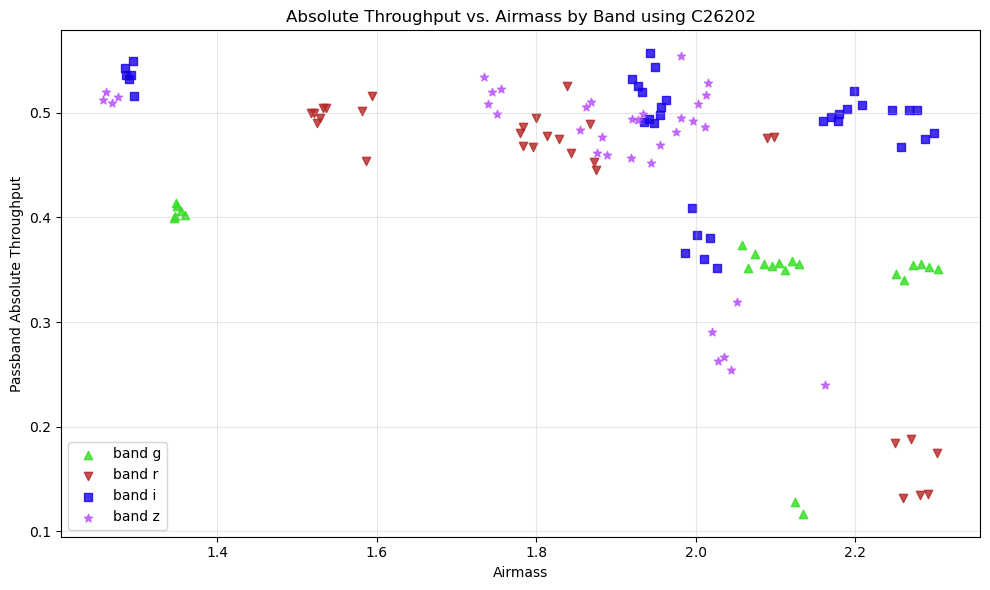

In [68]:
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop over filters
for band in flist:
    band_data = best_df[best_df['band'] == band]
    if len(band_data) > 0:
        plt.scatter(
            band_data["airmass"],
            band_data["abs_throughput"],
            label=f"band {band}",
            marker=filter_symbols[band], 
            c=filter_colors[band],
            alpha=0.8
        )

plt.xlabel("Airmass")
plt.ylabel("Passband Absolute Throughput")
plt.title(f"Absolute Throughput vs. Airmass by Band using {Star_Name}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### 8.3 Print summary statistics for each band

Let's output a nice table...

In [69]:
# Based on code retrieved from Claude-3.5-Sonnet and from CoPilot+GPT5

stats_data = []

for band in flist:
    # Extract and clean the data
    band_data = best_df.loc[best_df['band'] == band, 'abs_throughput']
    band_data = pd.to_numeric(band_data, errors='coerce')  # force numeric
    band_data = band_data.replace([np.inf, -np.inf], np.nan).dropna().values.astype(float)

    if len(band_data) > 0:
        # --- Option A: sigma-clipped stats ---
        mean_clip, median_clip, std_clip = sigma_clipped_stats(band_data, sigma=3.0, maxiters=5)
        stderr_clip = std_clip / np.sqrt(len(band_data))

        # --- Option B: robust median/MAD ---
        median_robust = np.median(band_data)
        std_robust = mad_std(band_data)
        stderr_robust = std_robust / np.sqrt(len(band_data))

        stats_data.append({
            'band': band,
            'n_band': len(band_data),
            'Mean (clip)': f"{mean_clip:.3f}",
            'Median (clip)': f"{median_clip:.3f}",
            'Std (clip)': f"{std_clip:.3f}",
            'StdErr (clip)': f"{stderr_clip:.3f}",
            'Median (robust)': f"{median_robust:.3f}",
            'Std (robust)': f"{std_robust:.3f}",
            'StdErr (robust)': f"{stderr_robust:.3f}"
        })
    else:
        stats_data.append({
            'band': band,
            'n_band': 0,
            'Mean (clip)': 'N/A',
            'Median (clip)': 'N/A',
            'Std (clip)': 'N/A',
            'StdErr (clip)': 'N/A',
            'Median (robust)': 'N/A',
            'Std (robust)': 'N/A',
            'StdErr (robust)': 'N/A'
        })

# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Display the full table
display(stats_df)
#print(stats_df.to_string(index=False))

# Display a truncated table
display(stats_df[['band', 'n_band', 'Mean (clip)', 'Median (clip)', 'StdErr (clip)']])


,band,n_band,Mean (clip),Median (clip),Std (clip),StdErr (clip),Median (robust),Std (robust),StdErr (robust)
0,u,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,g,23,0.369,0.356,0.024,0.005,0.356,0.014,0.003
2,r,29,0.417,0.477,0.134,0.025,0.477,0.034,0.006
3,i,36,0.488,0.503,0.055,0.009,0.503,0.029,0.005
4,z,35,0.460,0.494,0.089,0.015,0.494,0.034,0.006
5,y,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A


,band,n_band,Mean (clip),Median (clip),StdErr (clip)
0,u,0,N/A,N/A,N/A
1,g,23,0.369,0.356,0.005
2,r,29,0.417,0.477,0.025
3,i,36,0.488,0.503,0.009
4,z,35,0.460,0.494,0.015
5,y,0,N/A,N/A,N/A


**Let's stop here for now:**

In [70]:
print("Stopping here...")
raise StopExecution

Stopping here...


## 9. Sandbox